# Imports 

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from initialization import Location
from initialization import Grid
import pandas as pd
import seaborn as sns
from SIRD_initialization import Grid
import statistics


# Basic SIRD Model

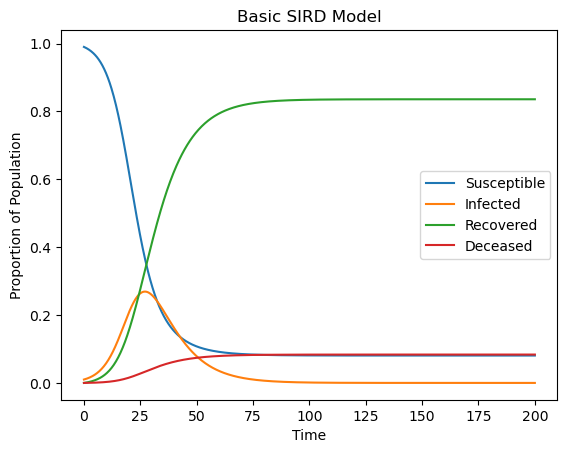

In [2]:
# Define the SIRD model differential equations.
def sird_model(y, t, beta, gamma, delta):
    S, I, R, D = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I - delta * I
    dRdt = gamma * I
    dDdt = delta * I
    return [dSdt, dIdt, dRdt, dDdt]

# Set the initial conditions and parameters.
initial_conditions = [0.99, 0.01, 0, 0]  # S, I, R, D
beta = 0.3  # Infection rate
gamma = 0.1  # Recovery rate
delta = 0.01  # Death rate

# Set the time points for the simulation.
t = np.linspace(0, 200, 1000)

# Solve the ODEs using odeint.
solution = odeint(sird_model, initial_conditions, t, args=(beta, gamma, delta))

# Extract the results.
S, I, R, D = solution.T

# Plot the results.
plt.plot(t, S, label='Susceptible')
plt.plot(t, I, label='Infected')
plt.plot(t, R, label='Recovered')
plt.plot(t, D, label='Deceased')
plt.xlabel('Time')
plt.ylabel('Proportion of Population')
plt.title('Basic SIRD Model')
plt.legend()
plt.show()


## Mobility Based SIRD Model - Random, High, Low

In [3]:
def calculate_averages(final_results, days, index):
    num_columns = days
    columns_sums = [0] * num_columns
    num_items = 0
    for key in final_results:
        sird = final_results[key][index]
        columns_sums = [columns_sums[i] + sird[i] for i in range(num_columns)]
        num_items += 1
    
    #print(num_items)
    average_sird = [sum_column / num_items for sum_column in columns_sums]
    return average_sird

        

In [4]:
def dynamic_alpha(type, threshold, beta, mu, N, n_locations, days, alpha_range, trials, c, delta_c, delta_g, birth_rate):
    alpha_sir = {}
    for alpha in alpha_range:
        final_results = {}
        for trial in range(trials):
    
            # Initialize grid and locations
            grid = Grid(n_locations, N, alpha, beta, mu, c)
            for loc in grid.map:
                print(loc.n)

            # Initialize random starting location based on chosen Mobility Type
            if type == "Random":
                grid.random_orgin()
            elif type == "High Mobility":
                grid.mobility_based_origin(threshold, True)
            else:
                grid.mobility_based_origin(threshold, False)

            susceptible = np.zeros(days)
            infectious = np.zeros(days)
            recovered = np.zeros(days) 
            dead = np.zeros(days)

            for day in range(days):
                for loc in grid.map:
                    if loc.n != 0:
                        infections, total_connections = get_other_loc_params(grid, loc)

                        # find new infections
                        new_infections = (beta * loc.s * loc.i/ loc.n) + ((alpha*loc.s*infections*beta)/(loc.n+total_connections))
                        # determine number of deaths and remove from population
                        infection_deaths = delta_c * loc.i
                        general_deaths_s = delta_g * loc.s
                        general_deaths_r = delta_g * loc.r
                        # determine new recoveris
                        new_recoveries = (mu * loc.i) / loc.n
                        loc.i += new_infections 
                        loc.s -= new_infections
                        
                        loc.i -= infection_deaths

                        loc.d += infection_deaths
                        
                        loc.s -= general_deaths_s
                        loc.d += general_deaths_s + general_deaths_r
                        loc.r -= general_deaths_r

                        loc.i -=  new_recoveries                        
                        loc.r += new_recoveries

                        loc.n = loc.s + loc.i + loc.r + loc.d

                        susceptible[day] = loc.s/loc.n
                        infectious[day] = loc.i/loc.n
                        recovered[day] = loc.r/loc.n
                        dead[day] = loc.d/loc.n

            
            
            final_results[str(trial)] = [susceptible, infectious, recovered, dead]

        susceptible = calculate_averages(final_results, days, 0)
        infectious = calculate_averages(final_results, days, 1)
        recovered = calculate_averages(final_results, days, 2)
        dead = calculate_averages(final_results, days, 3)
        alpha_sir[alpha] = [susceptible, infectious, recovered, dead]
    return alpha_sir

def sir_plotting(results, type):
    translation = {0:"S", 1:"I", 2:"R", 3:"D"}
    for key, values in results:
        plt.figure()
        for sublist in values:
            plt.plot(sublist, label=translation[values.index(sublist)])
            plt.title(f'SIR Model w/ {type} Mobility: Alpha = {key}')

        plt.legend()
        plt.xlabel("Generations")
        plt.ylabel("Population Density")
    plt.show()


def get_other_loc_params(grid,loc):
    infections = 0
    total_connections = 0
    for j in loc.connections:
        if grid.map[j].n != 0:
            infections += loc.connections[j] * (grid.map[j].i / grid.map[j].n)
            total_connections += loc.connections[j]
    
    return infections, total_connections

4
20
12
1
9
9
7
9
2
10
4
3
3
22
11
10
7
39
4
2
6
36
7
29
7
0
2
5
4
9
2
1
9
3
27
15
4
1
3
11
3
4
0
5
10
2
0
4
1
8
7
5
9
5
10
6
17
3
4
8
22
10
21
0
3
9
4
20
5
4
33
22
29
4
16
20
3
0
12
21
0
0
22
10
13
25
10
18
8
2
14
21
12
15
5
1
9
1
24
52
3
12
11
27
13
7
1
5
21
2
1
23
14
3
9
1
18
1
5
1
7
20
8
29
17
1
3
10
3
7
6
0
28
12
34
3
5
15
0
43
23
10
9
3
5
5
3
5
27
1
6
2
3
2
32
4
1
0
23
1
9
18
8
3
28
2
0
1
24
4
11
1
11
5
8
5
3
4
12
9
11
1
5
0
10
28
12
1
2
35
0
8
2
23
15
25
6
1
4
51
2
4
19
11
15
6
16
19
3
18
2
1
15
21
21
0
19
14
19
1
20
8
16
9
29
5
8
3
5
7
5
2
4
4
3
20
5
3
8
11
15
7
8
5
2
0
3
20
1
12
3
7
21
1
1
11
5
40
7
18
5
3
7
6
1
7
4
0
2
0
5
11
4
1
0
6
25
8
4
4
5
16
4
10
42
1
28
44
14
20
13
7
0
8
23
2
0
17
8
47
15
25
0
0
15
3
4
1
11
17
17
11
22
1
5
4
28
8
4
6
9
1
13
25
7
30
0
23
22
15
8
26
1
16
18
6
10
7
15
0
0
24
1
5
2
4
3
1
11
3
3
22
0
0
21
1
0
2
4
22
29
7
6
10
6
10
17
2
26
13
0
3
8
1
5
2
1
8
8
6
9
12
1
20
3
3
11
20
10
9
21
3
18
2
3
8
24
4
2
71
11
8
10
5
2
5
12
8
6
0
1
6
5
11
37
13
0
0
16
12


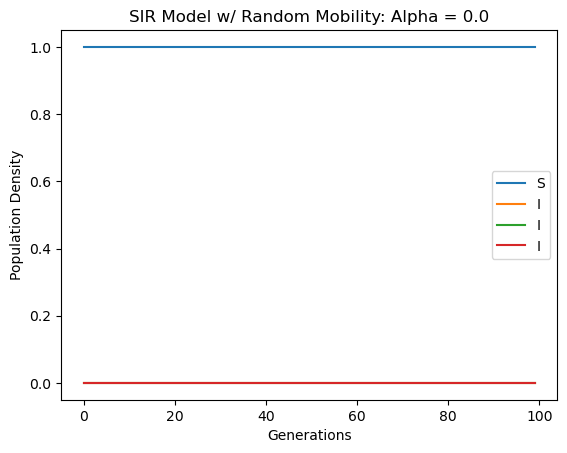

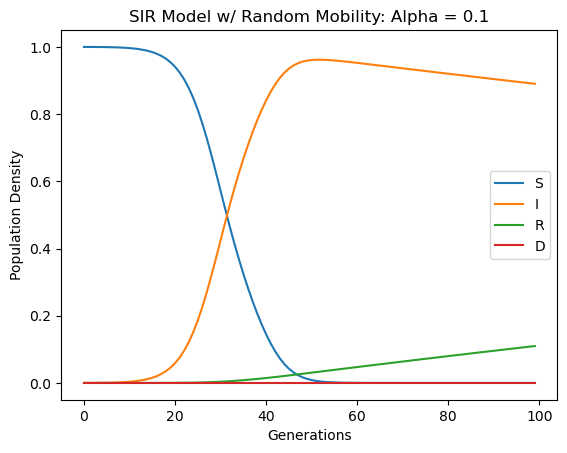

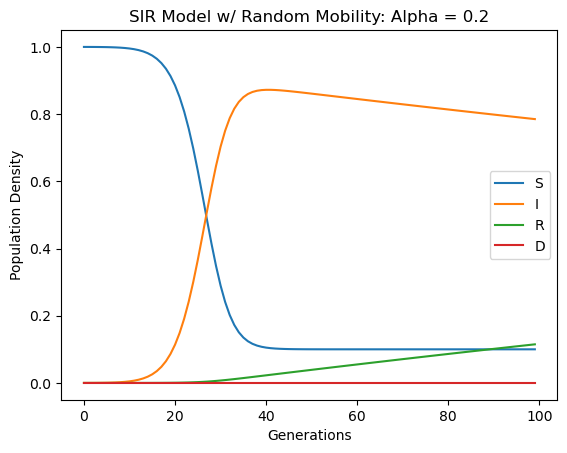

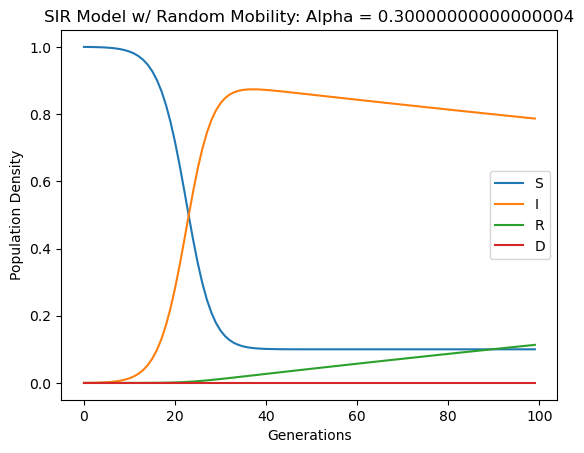

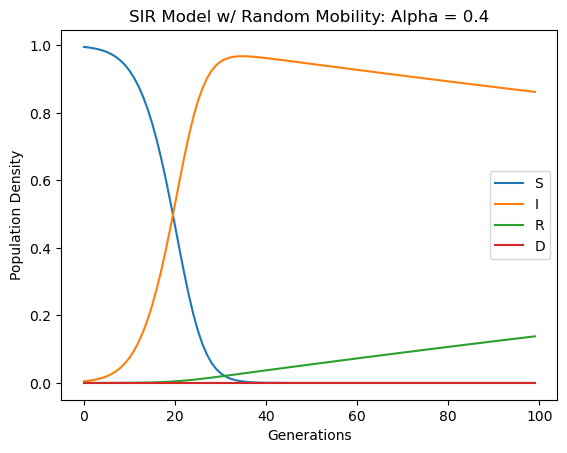

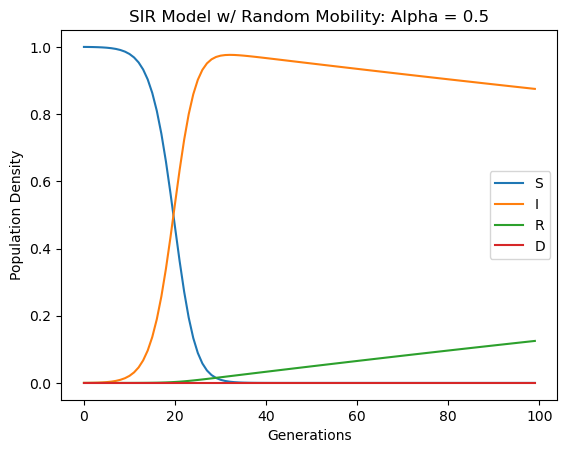

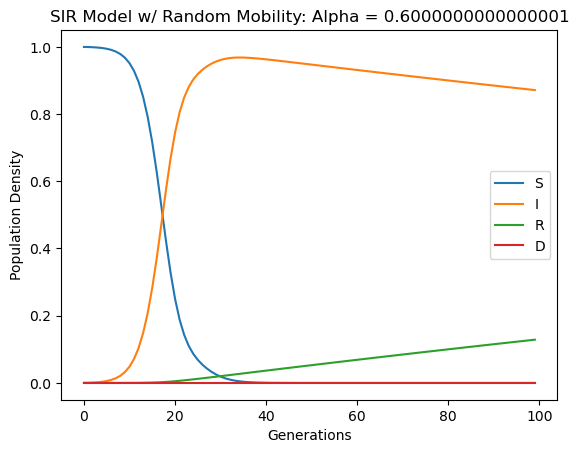

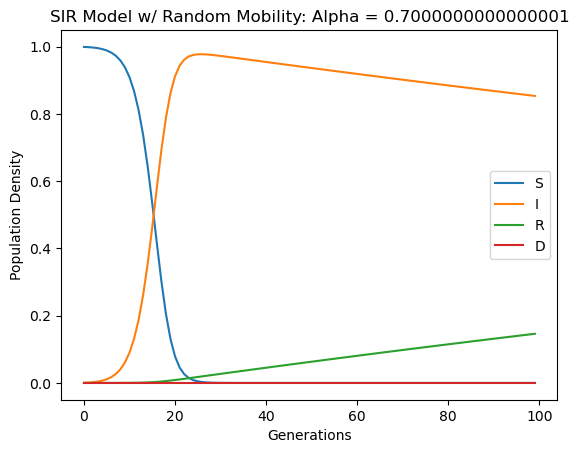

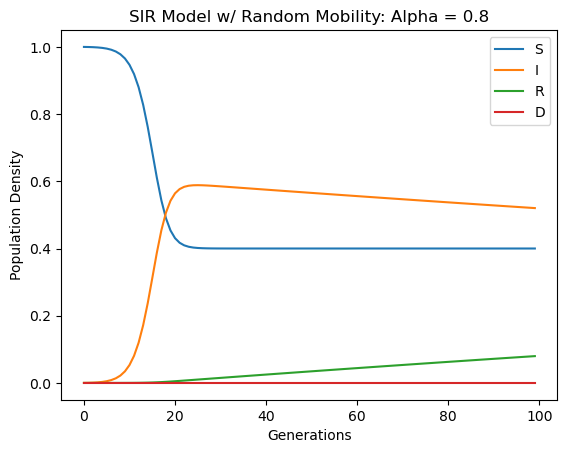

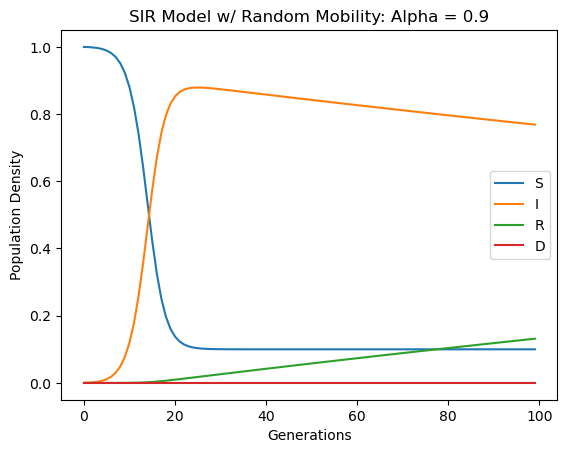

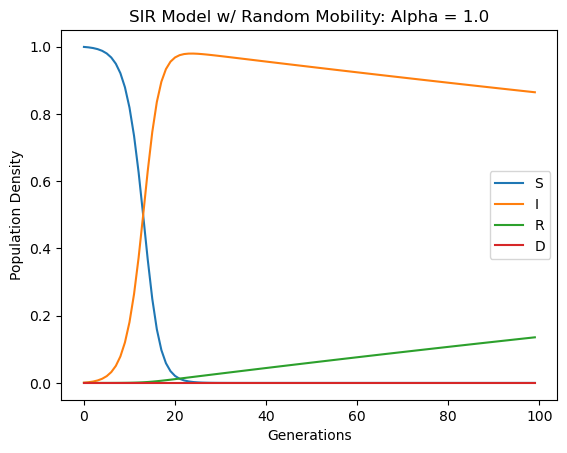

In [5]:
beta = 0.3 # rate of infection *CHANGE LATER MAYBE*
mu = 0.1 # rate of recovery *CHANGE LATER MAYBE*
delta_c = 0#0.004 # rate of death from COVID for Estonia
delta_g = 0#0.014 # general death rate in Estonia
birth_rate =0 # 0.009898
N = 1000
n_locations=100
days = 100
alphas = np.arange(0,1.1,0.1)
trials=10
c = 0
type = "Random"
threshold = 0.1
dynamic_alpha_results = dynamic_alpha(type, threshold, beta, mu, N, n_locations, days, alphas, trials, c, delta_c, delta_g, birth_rate)
sir_plotting(dynamic_alpha_results.items(), type)
